### Import dependencies

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import os
import sys
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import PIL
from PIL import Image
from collections import OrderedDict

import torch 
from torch import nn, optim 
from torch.optim import lr_scheduler 
from torch.autograd import Variable
import torchvision 
from torchvision import datasets, models, transforms 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

### Check GPU (in case you are not running this locally)

In [10]:
# CHECK IF GPU IS WORKING

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:    
  print('Training on CPU ...')
else:    
  print('You are good to go!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training on CPU ...


### Data Transformation

To make the the model more robust and flexible we should train it using images that are flipped, rotated, and cropped.

Here we will run a few transfromations on our dataset:

- we will use Torch's Torchvision.transform to do the transformations ([Documentation](https://pytorch.org/docs/stable/torchvision/transforms.html))

- we will use Torch's Torchvision.datasets.ImageFolder for our data loader ([Documentation](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder))

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(180),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

train_dir = "../content/train"
valid_dir = "../content/valid"

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(train_dir if x == 'train' else valid_dir), data_transforms[x])
                  for x in ['train', 'valid']}

# Define the dataloaders, using the image datasets and the trainforms
batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
               for x in ['train', 'valid']}

class_names = image_datasets['train'].classes
dataloaders_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [11]:
print(dataset_sizes)
print(dataloaders_sizes)
print(class_names)

{'train': 170, 'valid': 33}
{'train': 11, 'valid': 3}
['darkskin', 'oliveskin', 'porcelainskin']


### Mapping the Data
we have to now map the data to the labels. The dataset comes with a JSON file that contains this mapping. We will just have to load it.

In [2]:
with open('../content/skin.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'0': 'dark skin', '2': 'porcelain skin', '1': 'olive skin'}

### Model Selection and Training

Model used:
[densenet161](https://www.kaggle.com/pytorch/densenet161)

In [14]:
# choose which model to use
model = models.densenet161(weights='IMAGENET1K_V1')
# former version: model = models.densenet161(pretrained=True, weights='IMAGENET1K_V1')
num_in_features = 2208

In [15]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False

def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 3))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.5))
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
    return classifier


In [25]:
hidden_layers = None

classifier = build_classifier(num_in_features, hidden_layers, 3)
print(classifier)

# Only train the classifier parameters, feature parameters are frozen
model.classifier = classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())
sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)

Sequential(
  (fc0): Linear(in_features=2208, out_features=3, bias=True)
)


In [26]:
# Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, sched, num_epochs=5):
    """
        Train model for a given number of epochs,
        print loss and accuracy for each epoch.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward prpagate + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [27]:
epochs = 30
model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/30
----------
train Loss: 1.7594 Acc: 0.2765
valid Loss: 1.0938 Acc: 0.4848

Epoch 2/30
----------
train Loss: 1.2172 Acc: 0.4176
valid Loss: 1.0648 Acc: 0.4848

Epoch 3/30
----------
train Loss: 0.9328 Acc: 0.5412
valid Loss: 1.0469 Acc: 0.3939

Epoch 4/30
----------
train Loss: 1.0831 Acc: 0.5000
valid Loss: 0.9089 Acc: 0.4848

Epoch 5/30
----------
train Loss: 0.8318 Acc: 0.5647
valid Loss: 0.7881 Acc: 0.6970

Epoch 6/30
----------
train Loss: 0.7513 Acc: 0.6529
valid Loss: 0.6030 Acc: 0.7879

Epoch 7/30
----------
train Loss: 0.6728 Acc: 0.6765
valid Loss: 0.6630 Acc: 0.8182

Epoch 8/30
----------
train Loss: 0.6825 Acc: 0.6824
valid Loss: 1.1151 Acc: 0.4242

Epoch 9/30
----------
train Loss: 0.8044 Acc: 0.6706
valid Loss: 0.7979 Acc: 0.5758

Epoch 10/30
----------
train Loss: 0.5484 Acc: 0.7412
valid Loss: 0.6694 Acc: 0.7576

Epoch 11/30
----------
train Loss: 0.7018 Acc: 0.7000
valid Loss: 0.8279 Acc: 0.6061

Epoch 12/30
----------
train Loss: 0.5157 Acc: 0.7882
valid Los

### Evaluate the model's performance using other metrics.

- ##### Accuracy

In [40]:
# Model Evaluation

model.eval()

accuracy = 0

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

Test accuracy: 0.917


- ##### f1_score, precision_score, and recall_score

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

model.eval()

predicted_labels = []
true_labels = []

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)

    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Calculate evaluation metrics
# accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Print evaluation metrics
print("F1 score: {:.3f}".format(f1))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

# Plot accuracy and loss curves
# plt.plot(training_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


F1 score: 0.658
Precision: 0.802
Recall: 0.697


Confusion Matrix:
[[ 7  1  1]
 [ 1 12  0]
 [ 0  1 10]]


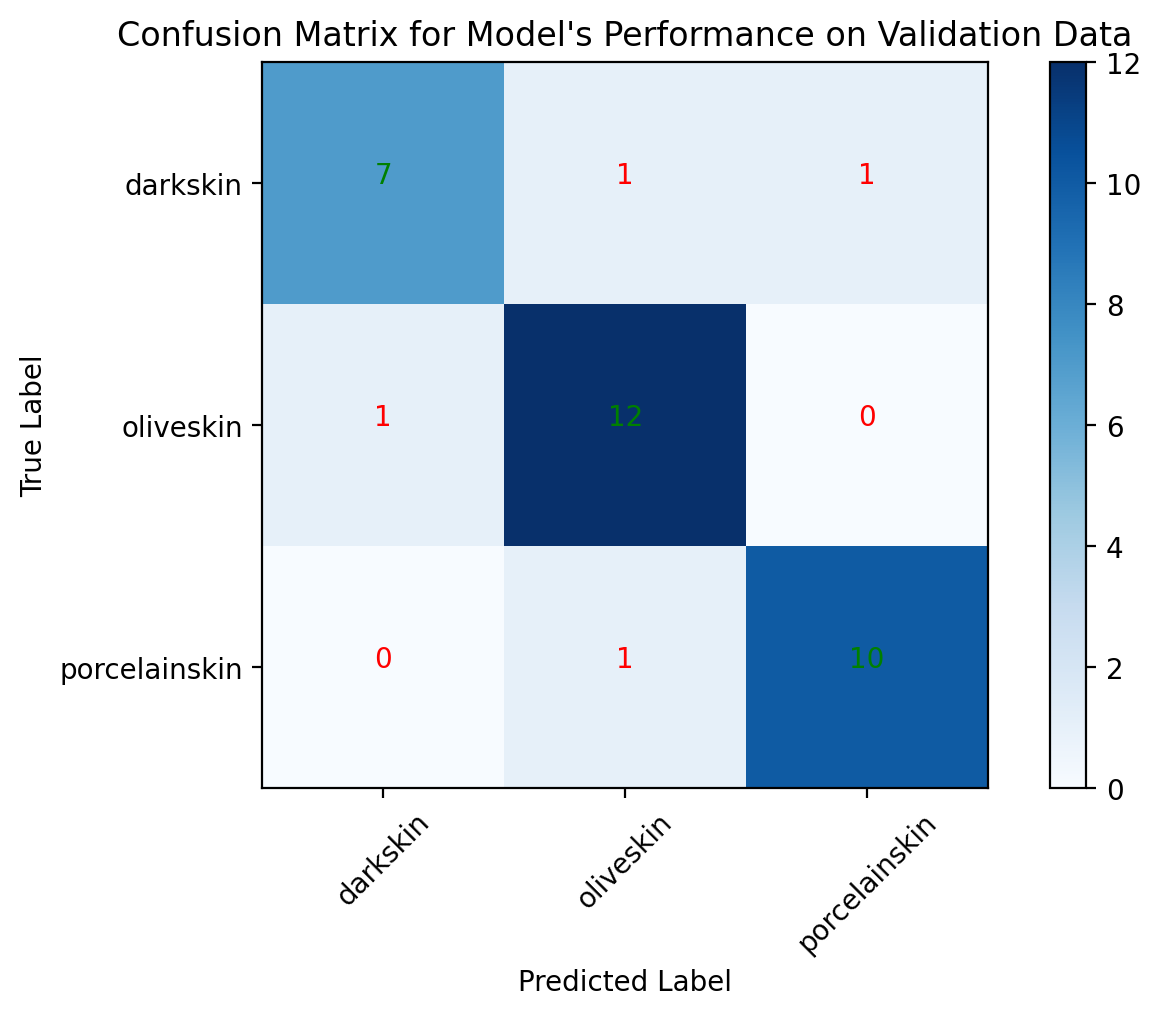

In [49]:
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(confusion)

# Define class labels
class_labels = class_names

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model\'s Performance on Validation Data')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Normalize the confusion matrix
normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# Add text annotations
thresh = normalized_confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, "{:,}".format(confusion[i, j]),
                 horizontalalignment="center",
                 color="green" if normalized_confusion[i, j] > thresh else "red")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [53]:
# # Define the evaluation function
# def evaluate_model(model, criterion, dataloader):
#     model.eval()
#     running_loss = 0.0
#     running_corrects = 0

#     # Iterate over the data
#     for inputs, labels in dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         with torch.no_grad():
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#         # Update statistics
#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

#     # Calculate metrics
#     loss = running_loss / len(dataloader.dataset)
#     accuracy = running_corrects.double() / len(dataloader.dataset)

#     return loss, accuracy


In [54]:
# train_losses = []
# valid_losses = []
# train_accuracies = []
# valid_accuracies = []

# # Evaluate model on training data
# train_loss, train_acc = evaluate_model(model, criterion, dataloaders['train'])
# train_losses.append(train_loss)
# train_accuracies.append(train_acc)

# # Evaluate model on validation data
# valid_loss, valid_acc = evaluate_model(model, criterion, dataloaders['valid'])
# valid_losses.append(valid_loss)
# valid_accuracies.append(valid_acc)

# # Plot the accuracy and loss curves
# num_epochs = epochs
# num_epochs = range(1, num_epochs + 1)

# # Plot training and validation accuracies
# plt.figure()
# plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
# plt.plot(epochs, valid_accuracies, 'r', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot training and validation losses
# plt.figure()
# plt.plot(epochs, train_losses, 'b', label='Training Loss')
# plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### Save the checkpoint of the trained model

In [55]:
# Map image classes to model classes
model.class_to_idx = image_datasets['train'].class_to_idx
model.class_to_idx

{'darkskin': 0, 'oliveskin': 1, 'porcelainskin': 2}

In [56]:
# create and save checkpoints
checkpoint = {'input_size': 2208,
              'output_size': 3,
              'epochs': epochs,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': sched,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, '../models/Skintone-Model/final_checkpoint_ic_d161.pth')

### Load and use model for image classification and prediction

In [14]:
# image_size = 224
# # Values used for normalizing the images. Default here are for pretrained models from torchvision.
# norm_mean = [0.485, 0.456, 0.406]
# norm_std = [0.229, 0.224, 0.225]

In [3]:
def load_checkpoint(filepath):
    """Load pre-trained model from the checkpoint."""
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    # checkpoint['input_size'] = 25088
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict = (checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']

    for param in model.parameters():
        param.requires_grad = False

    return model, checkpoint['class_to_idx']


In [6]:
# model, class_to_idx = load_checkpoint('./models/checkpoint_ic_d161.pth')
model, class_to_idx = load_checkpoint('../final_checkpoint_ic_d161.pth')
class_to_idx

{'darkskin': 0, 'oliveskin': 1, 'porcelainskin': 2}

In [62]:
def process_image(image):
    ''' Scale, crop, and normalize a PIL image for a PyTorch model,
        return an Numpy array.
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [63]:
import numpy as np
import torch

def tensor_to_image(tensor):
    """Convert the tensor output from 'process_image' to a numpy array."""
    tensor = tensor.cpu().detach().numpy()
    
    # Scale the values to [0, 255]
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    tensor = 255 * tensor
    
    # Convert the numpy array to an image array
    image_array = tensor.transpose((1, 2, 0)).astype(np.uint8)
    
    return image_array


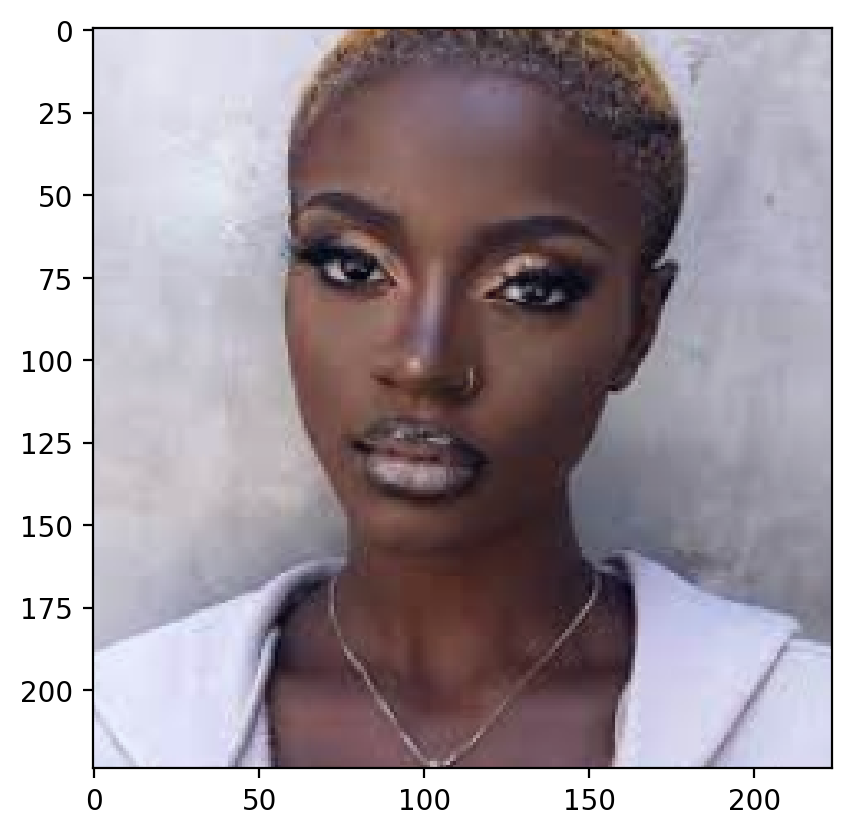

In [65]:
# Testing imshow function
with Image.open('../content/valid/darkskin/images.jpg') as image:
    processed_image = process_image(image)
    pil_image = tensor_to_image(processed_image)
    plt.imshow(pil_image)


In [66]:
def predict2(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''

    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vectorcle
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img)

    model.eval()
    inputs = Variable(img).to(device)
    # model.classifier[0] = nn.Linear(2208, 120, bias = True)

    logits = model.forward(inputs)

    ps = F.softmax(logits, dim=1)
    topk = ps.cpu().topk(topk)

    return (e.data.numpy().squeeze().tolist() for e in topk)



In [68]:
import plotly.graph_objects as go
import pandas as pd

# load the makeup dataset
rec = pd.read_csv('../content/makeup.csv')

def view_classify(img_path, prob, classes, cat_to_name, rec):
    ''' 
        Function for viewing an image, probability of it belonging to the classes.
        Also display recommended products based on class with highest probability
    '''
    image = Image.open(img_path)

    # Show the image being classified
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
    ax1.set_title('Uploaded Image')
    ax1.imshow(image)
    ax1.axis('off')
    print(f"Classes: {classes}")

    classes_dict = {0: "Dark skin", 1: "Olive skin", 2: "Porcelain skin"}
    # Show the prediction probability outputted by model for the image
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([classes_dict[i] for i in classes])
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Skintone Class Probability')

    # Set spacing between subplots
    plt.subplots_adjust(wspace=0.5)
    plt.show()

    # Select products equivalent to skintone of uploaded image
    skintype = cat_to_name[str(classes[0])]
    rec1 = rec.loc[rec['SkinTone'] == skintype][:3]

    # Display recommended products based on the model's predictions in tabular format
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(rec1.columns),
               fill_color='paleturquoise',
               align='left'),
    cells=dict(values=[rec1.Foundation, rec1.HEXColor, rec1.SkinTone,rec1.Company, rec1.ProductURL, rec1.Price, rec1.Image, rec1.VideoTutorial],
              fill_color='lavender',
              align='left'))
      ])
    fig.update_layout(
        title={
            'text': "Product Recommendations",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    fig.show()
    # print(rec1.to_dict())

    def make_clickable(val):
        # target _blank to open new window
        return '<a href="{}" target="_blank">{}</a>'.format(val, val)

    rec1['ProductURL'] = rec1['ProductURL'].apply(make_clickable)
    # rec1.style.format({'ProductURL': make_clickable})

    return (rec1)


Classes: [2, 1, 0]


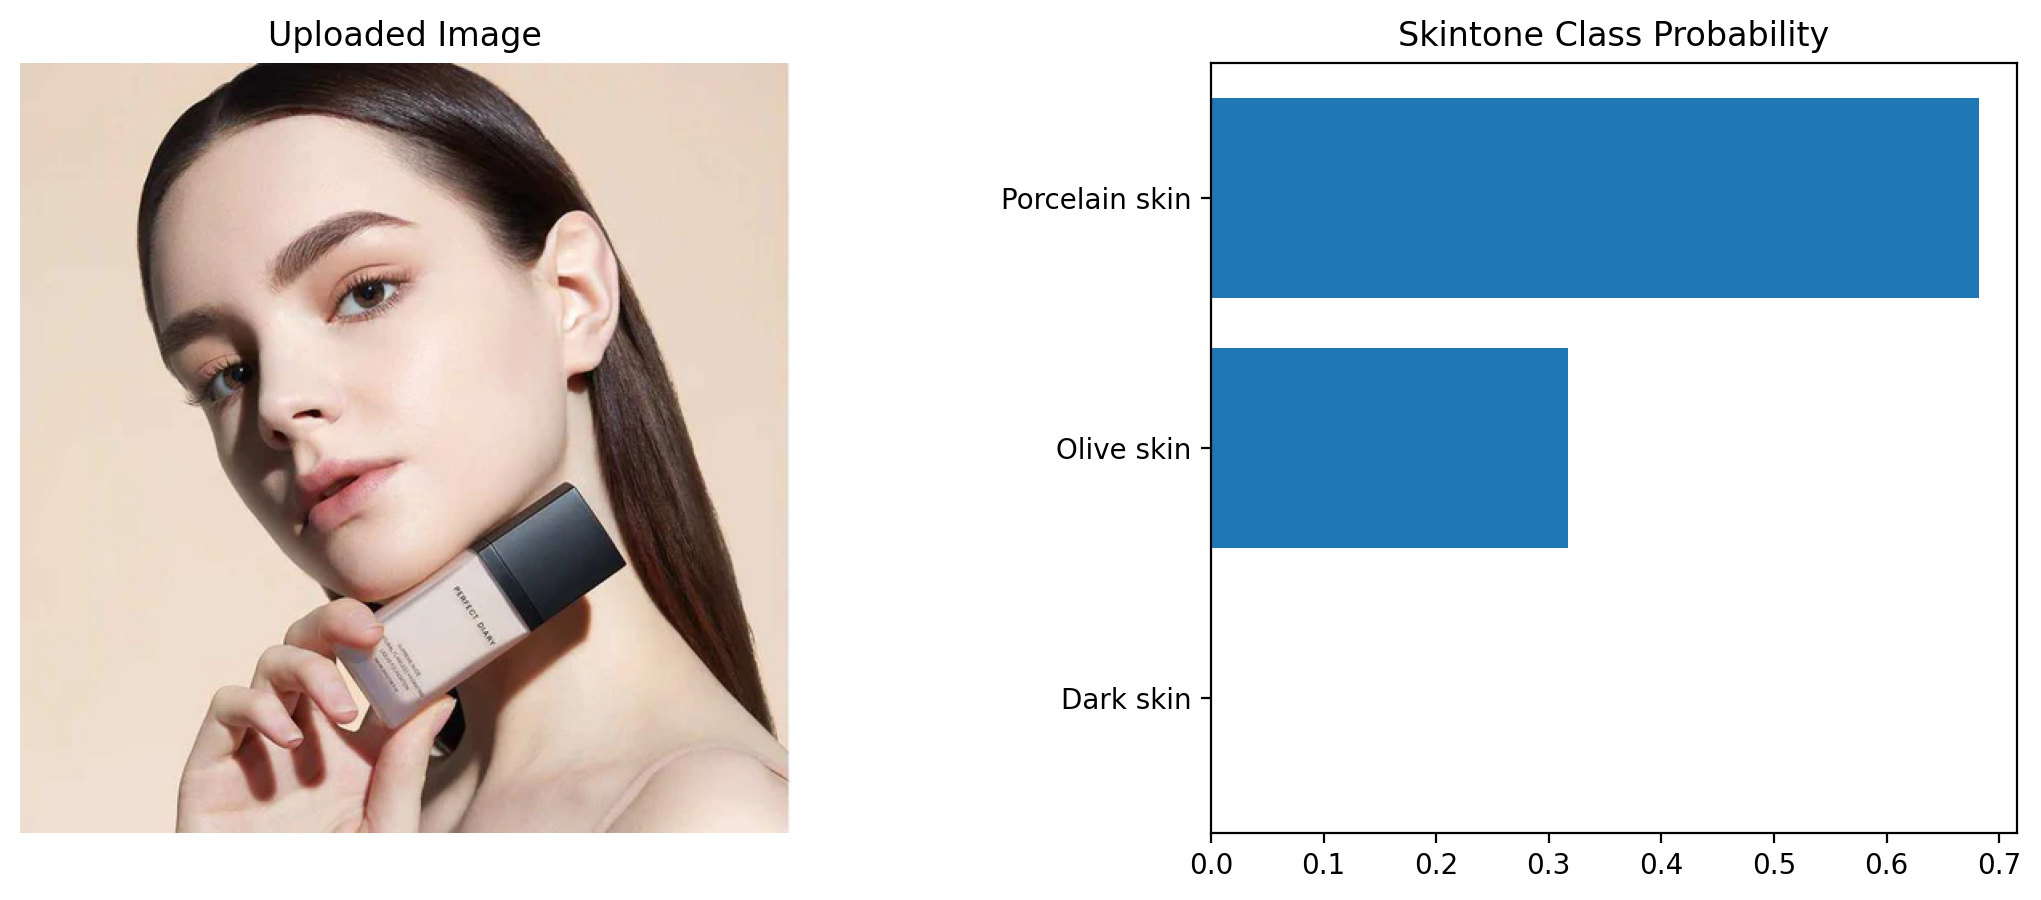

In [69]:
file = '../content/valid/porcelainskin/images.jpg'
probs, classes = predict2(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

Classes: [0, 2, 1]


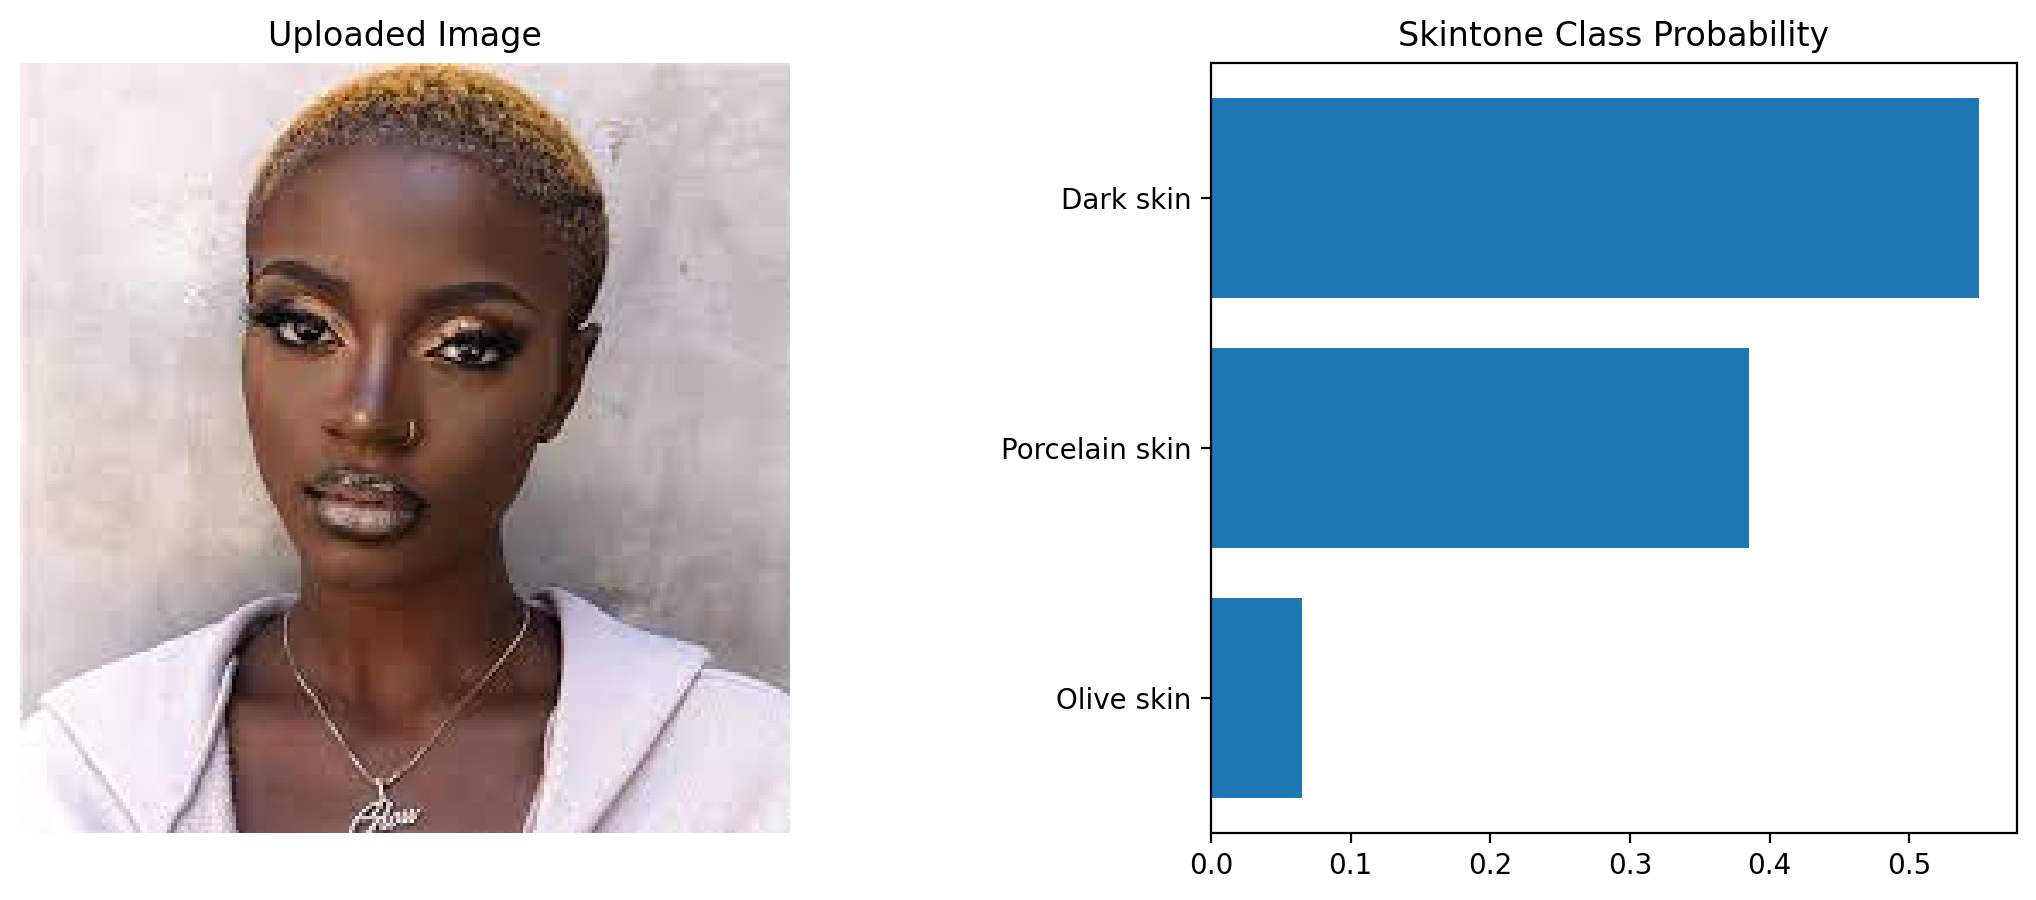

[0.5495957732200623, 0.385181188583374, 0.06522303819656372]
[0, 2, 1]


In [47]:
file = '../content/valid/darkskin/images.jpg'
probs, classes = predict2(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))
print(probs)
print(classes)

Classes: [1, 2, 0]


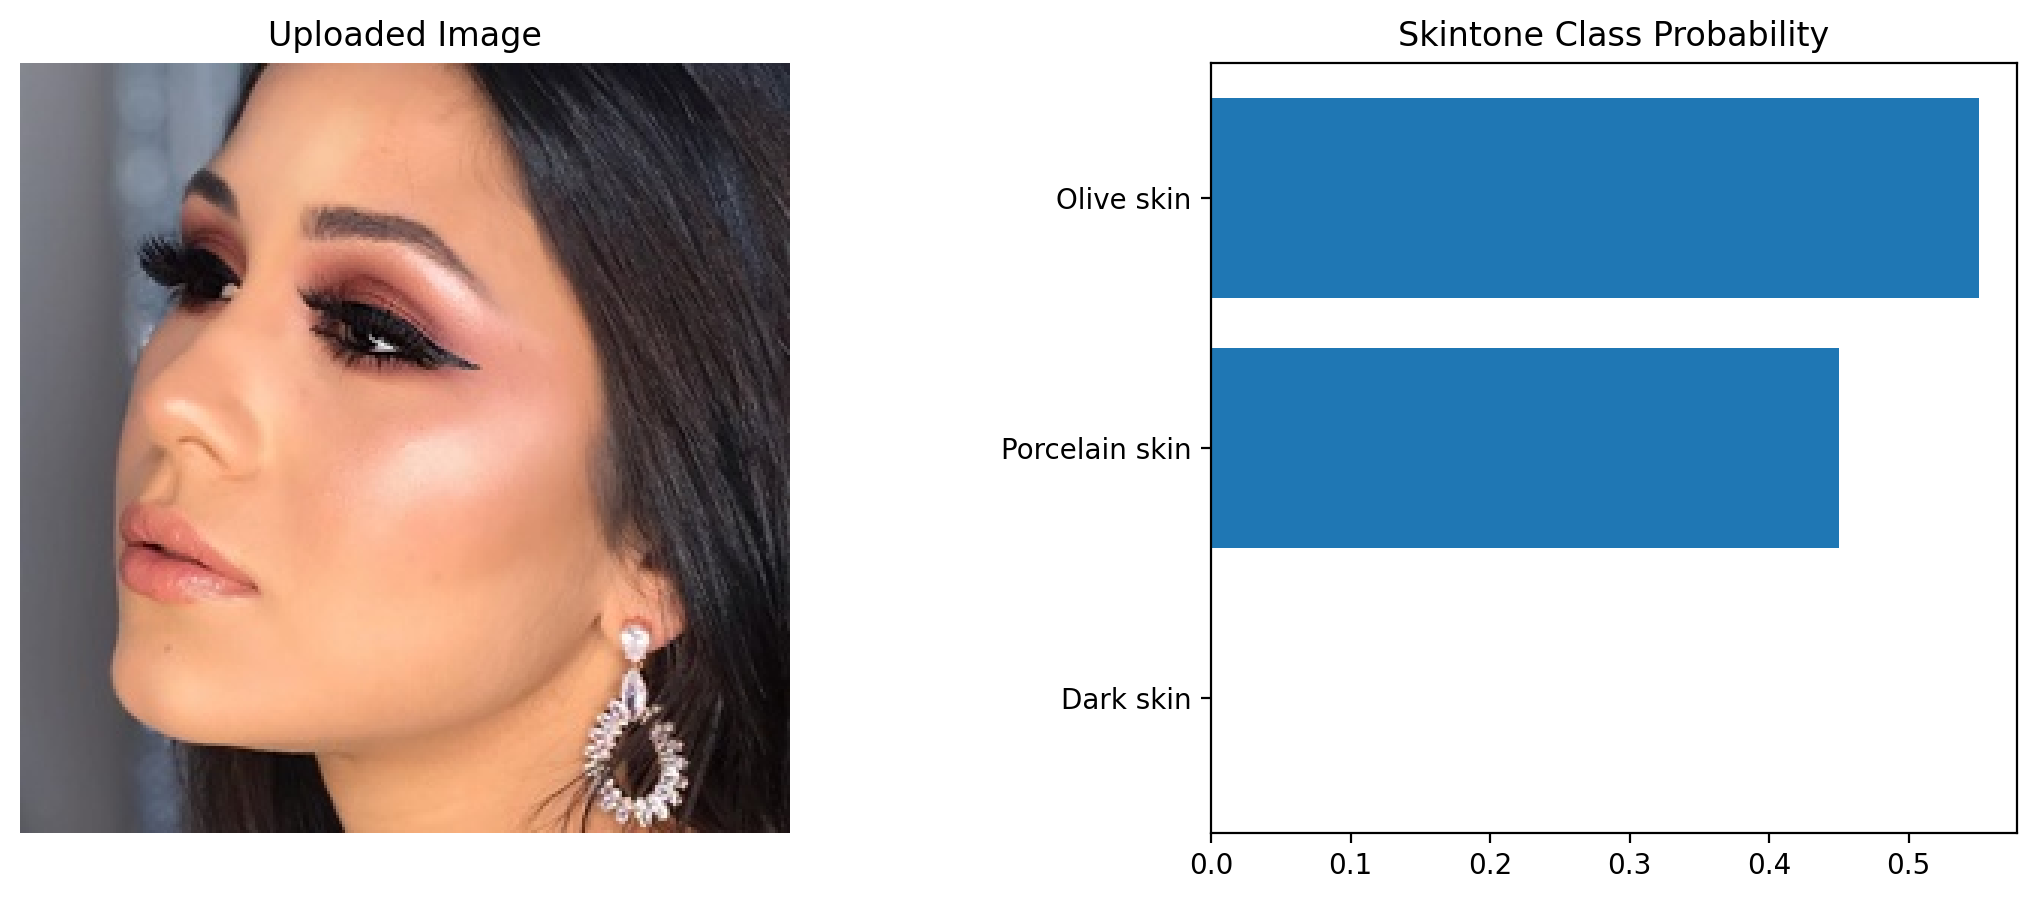

[0.5501787066459656, 0.4497853219509125, 3.598283728933893e-05]
[1, 2, 0]


In [76]:
file = '../content/valid/oliveskin/377.jpg'
probs, classes = predict2(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

print(probs)
print(classes)